In [50]:
%load_ext autoreload
%autoreload 2

import os
import pickle
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

while os.path.basename(os.getcwd()) != "T2T_ViT":
    os.chdir('..')

from datasets.datamodules import CIFAR10DataModule, GastroDataModule, DataModuleWithMasks, GenerateMasksKwargs
from lightning_modules.explainer import Explainer
from lightning_modules.surrogate import Surrogate
from vit_shapley.brute_shap import BruteShap
from vit_shapley.visualizations import get_heatmaps_grid
from vit_shapley.masks import apply_masks_to_batch, remake_masks, quick_test_masked

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datamodule = DataModuleWithMasks(
    CIFAR10DataModule(),
    # GastroDataModule(cropped=True),
    GenerateMasksKwargs(num_players=16),
    dict(batch_size=32)
)
datamodule.setup("test")
data = next(iter(datamodule.test_dataloader()))

images = data['image']
labels = data['label']
masks = data['mask']
print(images.shape, labels.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 16])


# Loading models

In [3]:
surrogates = {
    "vit": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/cifar10/v4/player16/vit_small_patch16_224",
    map_location="cuda",
),
    "t2t_vit": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/cifar10/v4/player16/t2t_vit_14",
    map_location="cuda",
),
    "swin": Surrogate.load_from_latest_checkpoint(
    "saved_models/surrogate/cifar10/v4/player16/swin_tiny_patch4_window7_224",
    map_location="cuda",
)}

for surrogate in surrogates.values():
    surrogate.eval()


adopt performer encoder for tokens-to-token


In [8]:
path_surrogates = {"v": "saved_models/surrogate/cifar10/v4/player196/vit_small_patch16_224",
                   "s": "saved_models/surrogate/cifar10/v4/player196/swin_tiny_patch4_window7_224",
                   "t": "saved_models/surrogate/cifar10/v4/player196/t2t_vit_14"}


def load_models(model_1, model_2):
    surrogate = Surrogate.load_from_latest_checkpoint(
    path_surrogates[model_1],
    map_location="cuda",
    )
    surrogate.eval()
    explainer = Explainer.load_from_latest_checkpoint(
        f"saved_models/explainer/cifar10/pairs/player196/{model_2}_on_{model_1}",
        map_location="cuda",
        surrogate=deepcopy(surrogate)
    )
    explainer.eval()
    return surrogate, explainer

In [22]:
explainers = {}
surrogates = {}
for model_name_1 in ["s", "v", "t"]:
    for model_name_2 in ["s", "v", "t"]:
        surrogates[model_name_1], explainers[f"{model_name_2}_on_{model_name_1}"] = load_models(model_name_1, model_name_2)

adopt performer encoder for tokens-to-token
adopt performer encoder for tokens-to-token
adopt performer encoder for tokens-to-token
adopt performer encoder for tokens-to-token
adopt performer encoder for tokens-to-token
adopt performer encoder for tokens-to-token


In [23]:
# For each explainer and for "True", a tensor of shape (len(images), num_players, num_classes).
shap_values = dict[str, torch.Tensor]()

In [24]:
for name, explainer in explainers.items():
    with torch.no_grad():
        shap_values[name] = explainer(images.cuda()).cpu()  # shape (len(images), num_players, num_classes).

In [25]:
# Limit to target class.
target_shap_values = dict[str, torch.Tensor]()
for name in shap_values.keys():
    target_shap_values[name] = shap_values[name][torch.arange(len(images)), :, labels]  # shape (len(images), num_players).

Check whether shapley values summed over players give the proper value (surrogate(unmasked image) - surrogate(fully masked image)).

# Check correlations

In [26]:
def pearson(x: torch.Tensor, y: torch.Tensor) -> float:
    correlation_matrix = torch.corrcoef(torch.stack([x.flatten(), y.flatten()]))
    return correlation_matrix[0, 1].item()


def scatter_plot_shap_values(x: str, y: str) -> None:
    plt.figure(figsize=(6, 6))
    plt.title(f"Correlation between {x} and {y} shap values")
    plt.xlabel(f"{x} shap value")
    plt.ylabel(f"{y} shap value")
    plt.scatter(
        shap_values[x].flatten(), shap_values[y].flatten(), marker='.', alpha=0.02, label="all classes"
    )
    plt.scatter(
        target_shap_values[x].flatten(), target_shap_values[y].flatten(),  marker='.', alpha=0.2, label="target class"
    )
    for lh in plt.legend().legend_handles:
        lh.set_alpha(1)

    # Make x and y axes have the same range, excluding outliers:
    q = 0.01
    all_series = [shap_values[x], target_shap_values[x], shap_values[y], target_shap_values[y]]
    lo = min(np.quantile(x, q) for x in all_series)
    hi = max(np.quantile(x, 1 - q) for x in all_series)
    plt.xlim(lo, hi)
    plt.ylim(lo, hi)
    plt.show()

    print(f"Pearson's correlation coefficient, all classes:  {pearson(shap_values[x], shap_values[y]):.2f}")
    print(f"Pearson's correlation coefficient, target class: {pearson(target_shap_values[x], target_shap_values[y]):.2f}")
    print(f"MAE,  all classes:  {(shap_values[x] - shap_values[y]).abs().mean().item():.2f}")
    print(f"MAE,  target class: {(target_shap_values[x] - target_shap_values[y]).abs().mean().item():.2f}")
    print(f"RMSE, all classes:  {(shap_values[x] - shap_values[y]).pow(2).mean().sqrt().item():.2f}")
    print(f"RMSE, target class: {(target_shap_values[x] - target_shap_values[y]).pow(2).mean().sqrt().item():.2f}")



In [16]:
target_shap_values.keys()

dict_keys(['s_on_v', 'v_on_v', 't_on_v'])

## Three explanations for ViT model

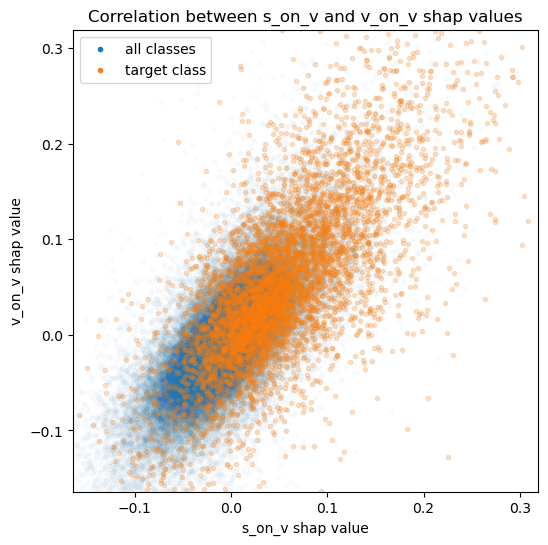

Pearson's correlation coefficient, all classes:  0.75
Pearson's correlation coefficient, target class: 0.73
MAE,  all classes:  0.03
MAE,  target class: 0.05
RMSE, all classes:  0.04
RMSE, target class: 0.06


In [21]:
scatter_plot_shap_values(x="s_on_v", y="v_on_v")

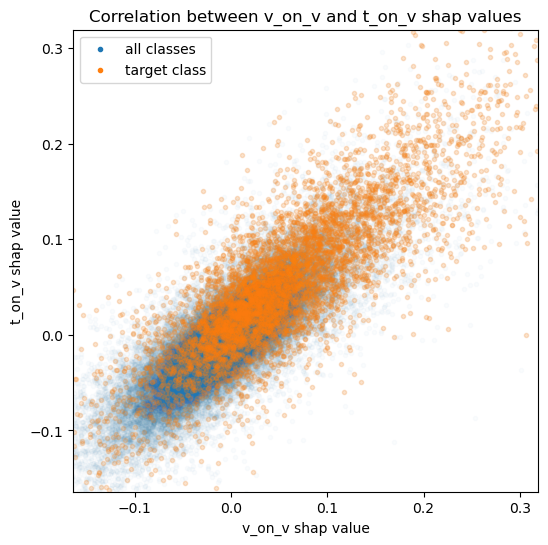

Pearson's correlation coefficient, all classes:  0.84
Pearson's correlation coefficient, target class: 0.84
MAE,  all classes:  0.03
MAE,  target class: 0.04
RMSE, all classes:  0.04
RMSE, target class: 0.05


In [18]:
scatter_plot_shap_values(x="v_on_v", y="t_on_v")

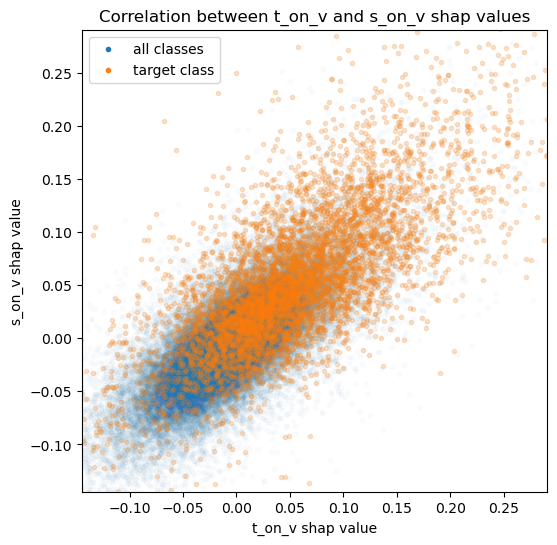

Pearson's correlation coefficient, all classes:  0.78
Pearson's correlation coefficient, target class: 0.75
MAE,  all classes:  0.03
MAE,  target class: 0.04
RMSE, all classes:  0.04
RMSE, target class: 0.05


In [19]:
scatter_plot_shap_values(x="t_on_v", y="s_on_v")

## Three explanations for T2T_ViT model

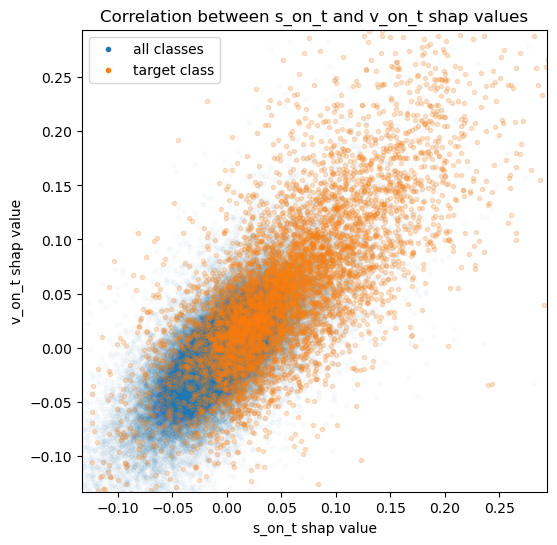

Pearson's correlation coefficient, all classes:  0.77
Pearson's correlation coefficient, target class: 0.74
MAE,  all classes:  0.03
MAE,  target class: 0.04
RMSE, all classes:  0.04
RMSE, target class: 0.05


In [27]:
scatter_plot_shap_values(x="s_on_t", y="v_on_t")

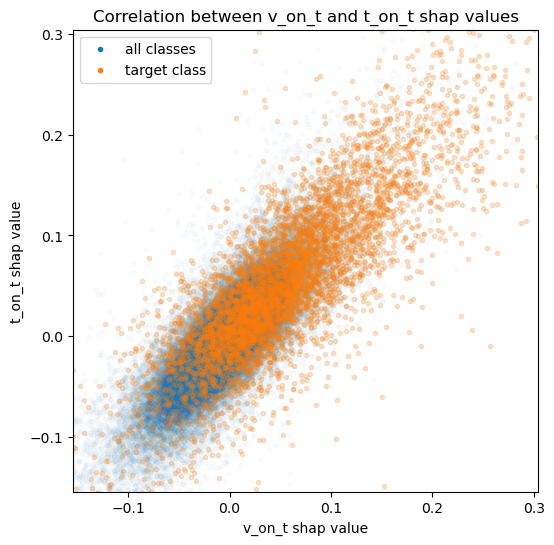

Pearson's correlation coefficient, all classes:  0.84
Pearson's correlation coefficient, target class: 0.83
MAE,  all classes:  0.02
MAE,  target class: 0.04
RMSE, all classes:  0.03
RMSE, target class: 0.05


In [28]:
scatter_plot_shap_values(x="v_on_t", y="t_on_t")

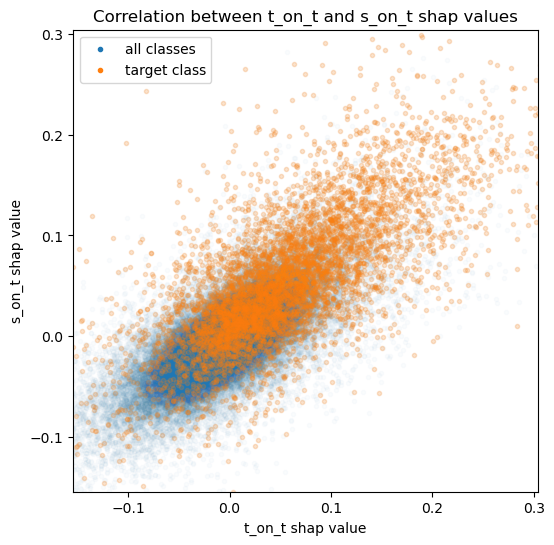

Pearson's correlation coefficient, all classes:  0.75
Pearson's correlation coefficient, target class: 0.73
MAE,  all classes:  0.03
MAE,  target class: 0.04
RMSE, all classes:  0.04
RMSE, target class: 0.06


In [29]:
scatter_plot_shap_values(x="t_on_t", y="s_on_t")

## Three explanations for Swin model

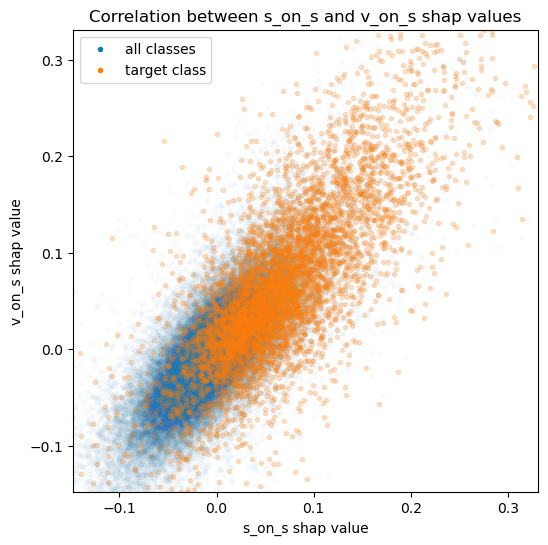

Pearson's correlation coefficient, all classes:  0.79
Pearson's correlation coefficient, target class: 0.77
MAE,  all classes:  0.03
MAE,  target class: 0.04
RMSE, all classes:  0.04
RMSE, target class: 0.06


In [30]:
scatter_plot_shap_values(x="s_on_s", y="v_on_s")

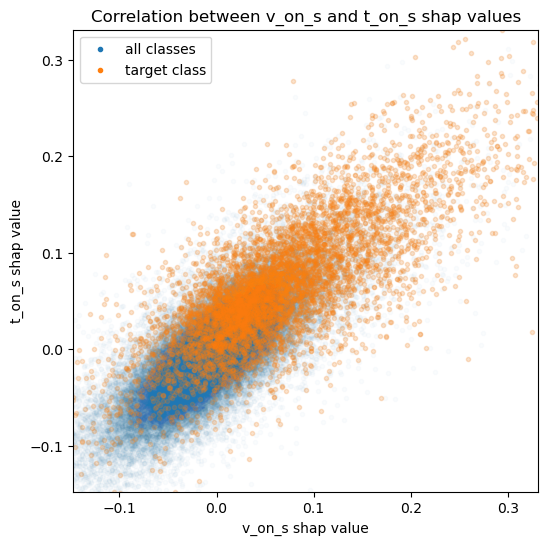

Pearson's correlation coefficient, all classes:  0.81
Pearson's correlation coefficient, target class: 0.79
MAE,  all classes:  0.03
MAE,  target class: 0.04
RMSE, all classes:  0.04
RMSE, target class: 0.05


In [31]:
scatter_plot_shap_values(x="v_on_s", y="t_on_s")

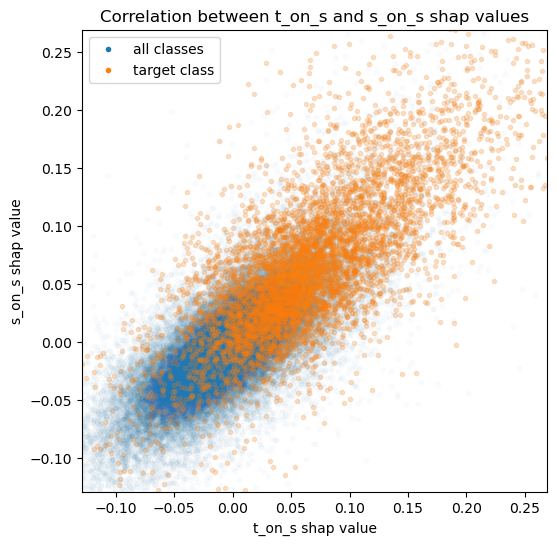

Pearson's correlation coefficient, all classes:  0.79
Pearson's correlation coefficient, target class: 0.76
MAE,  all classes:  0.03
MAE,  target class: 0.04
RMSE, all classes:  0.04
RMSE, target class: 0.05


In [32]:
scatter_plot_shap_values(x="t_on_s", y="s_on_s")

# Test best/worst/closest/furthest feature masking

In [35]:
shap_values.keys()

dict_keys(['s_on_s', 'v_on_s', 't_on_s', 's_on_v', 'v_on_v', 't_on_v', 's_on_t', 'v_on_t', 't_on_t'])

In [51]:
import IPython.display
import ipywidgets
from typing import Literal

def test_masked(
    surrogate: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    explainer: torch.nn.Module,
    players_to_mask: Literal["best", "worst", "random", "central", "peripheral"],
    device="cuda"
) -> None:
    results = []
    masked_percentages = []
    explainer.eval()
    surrogate.eval()
    with torch.no_grad():
        explainer.to(device)
        surrogate.to(device)
        correct, total = 0, 0
        with tqdm(dataloader, desc=players_to_mask) as dataloader_progress:
            for batch in dataloader_progress:
                images, masks, targets = batch['image'], batch['mask'], batch['label']
                images, masks, targets = images.to(device), masks.to(device), targets.to(device)
                shap_values = explainer(images) if (players_to_mask in ["best", "worst"]) else None
                masks = remake_masks(images, masks, targets, players_to_mask, explainer.num_players, shap_values)
                masks = masks.to(device)
                images, masks, targets = apply_masks_to_batch(images, masks, targets)

                logits = surrogate(images)
                _, predicted = logits.max(dim=1)
                total += targets.shape[0]
                correct += predicted.eq(targets).sum().item()
                results.extend(predicted.eq(targets).cpu().numpy())
                masked_percentages.extend((1 - masks.float()).mean(dim=1).cpu().numpy() * 100)
                dataloader_progress.set_postfix_str(f'Accuracy: {100.0 * correct / total:.2f}%')
    return pd.DataFrame({'result': results, 'masked %': masked_percentages})

all_results = {}

In [52]:
import IPython.display
import ipywidgets

def plot(all_results: dict[str, pd.DataFrame], bucket_size: float = 100 / 14, img_name="intgrad_vit.png") -> None:
    # Smooth the plot by rounding 'masked %' to the nearest multiple of bucket_size.
    plot_results = deepcopy(all_results)
    for k, df in plot_results.items():
       df['masked %'] = df['masked %'].div(bucket_size).round().astype(int).mul(bucket_size)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    for i, ax in enumerate(axs):
        for k, df in plot_results.items():
            ax.errorbar(
                x=list(df.groupby('masked %').groups.keys()),
                y=df.groupby('masked %').mean()["result"].to_list(),
                yerr=df.groupby('masked %').sem()["result"].mul(3).to_list(),
                label=k
            )
        ax.plot([0, 100], [0.97, 0.97], color='black', linestyle='dashed', linewidth=0.7, label='97%')
        ax.legend()
        ax.set_xlabel('masked %')
        ax.set_ylabel('accuracy')
        if i == 0:
            ax.set_xlim(0, 100)
            ax.set_ylim(0.4, 1)
        else:
            ax.set_xlim(0, 20)
            ax.set_ylim(0.9, 1)
    plt.show()
    plt.savefig(img_name)

# Make a sub-output for updating the plot live.
plot_output = ipywidgets.Output()
IPython.display.display(plot_output)

def plot_results(surrogate_model_name, explainer_model_name):
    all_results = {}
    explainer = explainers[explainer_model_name]
    surrogate = surrogates[surrogate_model_name]
    with tqdm(range(2), desc="repeats") as repeats:
        for repeat in repeats:
            for players_to_mask in ["best", "worst", "central", "peripheral", "random"]:
                # Update plot
                plot_output.clear_output(wait=False)
                with plot_output:
                    plot(all_results)
                # Test and update results
                df = test_masked(surrogate, datamodule.test_dataloader(), explainer, players_to_mask)
                if players_to_mask not in all_results:
                    all_results[players_to_mask] = df
                else:
                    all_results[players_to_mask] = pd.concat([all_results[players_to_mask], df])
        print(f'For the model explainer {explainer_model_name} the results are: ')


# Update plot
    plot_output.clear_output(wait=True)
    with plot_output:
        plot(all_results)

Output()

In [53]:
print(explainers.keys())

dict_keys(['s_on_s', 'v_on_s', 't_on_s', 's_on_v', 'v_on_v', 't_on_v', 's_on_t', 'v_on_t', 't_on_t'])


In [54]:
print(surrogates.keys())

dict_keys(['s', 'v', 't'])


In [55]:
plot_output = ipywidgets.Output()
IPython.display.display(plot_output)

plot_results("v", "s_on_v")

Output()

repeats:   0%|          | 0/2 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

For the model explainer s_on_v the results are: 


<Figure size 640x480 with 0 Axes>

In [56]:
plot_output = ipywidgets.Output()
IPython.display.display(plot_output)

plot_results("v", "t_on_v")

Output()

repeats:   0%|          | 0/2 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

For the model explainer t_on_v the results are: 


<Figure size 640x480 with 0 Axes>

In [57]:
plot_output = ipywidgets.Output()
IPython.display.display(plot_output)

plot_results("v", "v_on_v")

Output()

repeats:   0%|          | 0/2 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

best:   0%|          | 0/313 [00:00<?, ?it/s]

worst:   0%|          | 0/313 [00:00<?, ?it/s]

central:   0%|          | 0/313 [00:00<?, ?it/s]

peripheral:   0%|          | 0/313 [00:00<?, ?it/s]

random:   0%|          | 0/313 [00:00<?, ?it/s]

For the model explainer v_on_v the results are: 


<Figure size 640x480 with 0 Axes>